In [1]:
import tensorflow as tf
import mplfinance as mpf
import tensorflow.keras as keras
import tensorflow.keras.utils as utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ta
import datetime

In [2]:
csvFileAddress = input('csv file address') 

DJ = pd.read_csv(csvFileAddress,delim_whitespace=True)

DJ.drop(['<VOL>'],axis=1,inplace=True)


timeFrame = (int(DJ.iloc[1][1][1])-int(DJ.iloc[0][1][1]) ) * 60 + (int(DJ.iloc[1][1][3:5])-int(DJ.iloc[0][1][3:5]))
CandlesInDay = 24 * (60//timeFrame)
timeFrame
def candleToTime(j):
    minuteMult = CandlesInDay//24
    k=j//minuteMult
    sth=timeFrame*(j%minuteMult)
    return '{:02d}:{:02d}:00'.format(k,sth)

uniqueDays = DJ.drop_duplicates(subset='<DATE>')
uniqueDays = pd.DataFrame(uniqueDays)

uniqueDaysCount=uniqueDays.shape[0]

newnumparr = np.full((uniqueDaysCount*CandlesInDay,2),'',dtype=np.object_)


for i in range(uniqueDaysCount):
    for j in range(CandlesInDay):
        newnumparr[(i*CandlesInDay)+j]=[uniqueDays.iloc[i][0],candleToTime(j)]

newDF = pd.DataFrame(newnumparr,columns=['<DATE>','<TIME>'])

newestDF = newDF.merge(DJ,on=['<DATE>','<TIME>'],how='left')

newestDF.fillna(0,inplace=True)

uniqueDaysCount

newestDF.head()

,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<TICKVOL>,<SPREAD>
0,2021.01.20,00:00:00,0.0,0.0,0.0,0.0,0.0,0.0
1,2021.01.20,00:05:00,0.0,0.0,0.0,0.0,0.0,0.0
2,2021.01.20,00:10:00,0.0,0.0,0.0,0.0,0.0,0.0
3,2021.01.20,00:15:00,0.0,0.0,0.0,0.0,0.0,0.0
4,2021.01.20,00:20:00,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
timeFrame = (int(newestDF.iloc[1]['<TIME>'][1])-int(newestDF.iloc[0]['<TIME>'][1]) ) * 60 + (int(newestDF.iloc[1]['<TIME>'][3:5])-int(newestDF.iloc[0]['<TIME>'][3:5]))
CandlesInDay = 24 * (60//timeFrame)
uniqueDaysCount = len(newestDF)//CandlesInDay

In [4]:
startCandleHour = 9.5
startCandleIndex = int(startCandleHour * CandlesInDay )// 24

windowLengthHour = 1.25
windowLengthCount = int(windowLengthHour * CandlesInDay) // 24


labelStartCandleHour = startCandleHour+windowLengthHour
labelStartCandleIndex = int(labelStartCandleHour * CandlesInDay) // 24

labelWindowLengthHour = 1
labelWindowLengthCount = int(labelWindowLengthHour * CandlesInDay) // 24


In [5]:
takeProfitPoints = 1.0015
stopLoss = .9985

df = newestDF.drop(['<DATE>'],axis=1)

trainNPs = []
labelsDFs = []
labelValues = []
trainDFs = []

maxValues = df.max()

for i in range(0,len(df)-CandlesInDay , CandlesInDay):
    trainDF = df.iloc[i+startCandleIndex : (i+startCandleIndex +windowLengthCount)]
    labelDF = df.iloc[i+labelStartCandleIndex :(i+labelStartCandleIndex+labelWindowLengthCount) ]

    lowestIndex = labelDF['<LOW>'].idxmin()
    lowestPriceInLabels = labelDF['<LOW>'][lowestIndex]

    highesIndex = labelDF['<HIGH>'].idxmax()
    highestPriceInLabels = labelDF['<HIGH>'][highesIndex]

    TP = labelDF['<OPEN>'].iloc[0]*takeProfitPoints
    SL = labelDF['<OPEN>'].iloc[0]*stopLoss

    buySignal = 0

    if highestPriceInLabels < TP and lowestPriceInLabels > SL:
        # ideas : halfTP
        buySignal=2
        
    elif highestPriceInLabels < TP and lowestPriceInLabels < SL:
        buySignal = 0
    elif highestPriceInLabels > TP and lowestPriceInLabels > SL:
        buySignal = 1
    else :
        tpIndex = 0
        slIndex = 0
        for j in range(len(labelDF)):
            if labelDF['<HIGH>'].iloc[j] > TP and labelDF['<LOW>'].iloc[j]>SL :
                tpIndex=j
            if labelDF['<HIGH>'].iloc[j] < TP and labelDF['<LOW>'].iloc[j]>SL :
                continue
            if labelDF['<HIGH>'].iloc[j] < TP and labelDF['<LOW>'].iloc[j]<SL :
                slIndex=j
        buySignal = int(tpIndex<slIndex)
        if slIndex==tpIndex:
            continue
    

    # trainDF =  trainDF /df.abs().max()

    # trainDF = trainDF.drop(['<OPEN>','<ATR_24>','<EMA30>','<RSI>','<CCI>','<KELTNER_M>','<KELTNER_L>','<KELTNER_H>','<GREEN>'],axis=1)
    trainDFColumnsArr = ['<TIME>','<LOW>','<HIGH>','<OPEN>','<CLOSE>','<TICKVOL>']
    trainDFColumnsExcludeTime = trainDFColumnsArr[1:]
    
    trainDF = trainDF[trainDFColumnsArr]
    trainDF['<TIME>']=pd.to_datetime(trainDF['<TIME>'],infer_datetime_format=1)



    # trainDF[trainDFColumnsExcludeTime]=(trainDF[trainDFColumnsExcludeTime]-df[trainDFColumnsExcludeTime].min())/(df[trainDFColumnsExcludeTime].max()-df[trainDFColumnsExcludeTime].min())
    
    trainNp =(trainDF.to_numpy(dtype=np.float32))
    # trainNp = np.rot90( trainDF.to_numpy())


    labelValues.append(buySignal)
    trainNPs.append(trainNp)
    trainDFs.append(trainDF)
    
    labelsDFs.append(labelDF)


In [6]:
len(trainDFs),len(labelValues)

(359, 359)

In [7]:
pd.DataFrame(labelValues,columns=['signal']).value_counts()

signal
0         166
1         133
2          60
dtype: int64

In [8]:
# tempDF = trainDFs[5]
# tempLabel = labelValues[5]
# tempDF.columns=['Datetime','Low','High','Open','Close','Volume']


# mpf.plot(tempDF.set_index('Datetime',),type='candle',volume=True,figsize=(5,5),axisoff=True)


In [9]:
import io
trainData = []
for i in range(len(trainDFs)):
    if i%100 == 0:
        print(i)
    tempDF = trainDFs[i]
    tempLabel = labelValues[i]
    tempDF.columns=['Datetime','Low','High','Open','Close','Volume']
    buf = io.BytesIO()
    mpf.plot(tempDF.set_index('Datetime',),type='candle',volume=True,figsize=(3,3),savefig=buf,axisoff=True)
    buf.seek(0)
    data =buf.read() 
    trainData.append(tf.io.decode_png(data).numpy())
    buf.close()



0
100
200
300


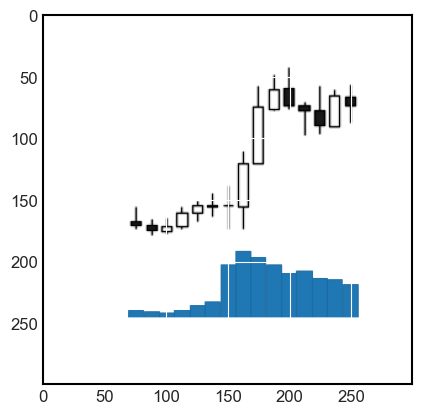

In [10]:
plt.imshow(trainData[4])

In [11]:
len(trainData),len(labelValues)

(359, 359)

In [12]:

trainDataCut,valData = trainData[:int(.8*len(trainData))],trainData[int(.8*len(trainData))+1:]
trainLablesCut,valLabels = labelValues[:int(.8*len(labelValues))],labelValues[int(.8*len(labelValues))+1:]

In [15]:
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten

tf.random.set_seed(42)

model = keras.Sequential([
    Conv2D(30,5,input_shape=(300,300,4),activation='relu'),
    Conv2D(30,5,activation='relu'),
    MaxPooling2D(3),
    Conv2D(30,5,activation='relu'),
    Conv2D(30,5,activation='relu'),
    MaxPooling2D(3),
    Conv2D(30,5,activation='relu'),
    Conv2D(30,5,activation='relu'),
    MaxPooling2D(3),
    Flatten(),
    Dense(30,activation='relu'),
    Dense(3,activation='softmax'),
    
])

# model.summary()

model.compile(
            loss=keras.losses.sparse_categorical_crossentropy,
            optimizer = keras.optimizers.Adam(),
            metrics=['accuracy']
)


In [16]:
train_x = np.asarray(trainDataCut)
train_y = np.asarray(trainLablesCut)
validation_x = np.asarray(valData)
validation_y = np.asarray(valLabels)


model.fit(train_x,train_y,epochs=20,validation_data=(validation_x,validation_y),verbose=2,)

Epoch 1/20
9/9 - 12s - loss: 11.1903 - accuracy: 0.3136 - val_loss: 1.2492 - val_accuracy: 0.2394 - 12s/epoch - 1s/step
Epoch 2/20
9/9 - 11s - loss: 1.1855 - accuracy: 0.3763 - val_loss: 1.1260 - val_accuracy: 0.4366 - 11s/epoch - 1s/step
Epoch 3/20
9/9 - 11s - loss: 1.0578 - accuracy: 0.4774 - val_loss: 1.0311 - val_accuracy: 0.4366 - 11s/epoch - 1s/step
Epoch 4/20


KeyboardInterrupt: 